In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 1.0  # final time
rA = 1.5   # maximum interaction distance

seed=17

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': muR*ratio, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a': 7.51}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [4]:
force_names = ['cubic', 'pw. quad.', 'GLS']


defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

In [5]:
solvers_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, 1), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, 1),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, 1)}
solvers_eb = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), eb.solve_ivp, 1), 
             'cubic': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, 1),
             'GLS': cbmos.CBModel(ff.Gls(), eb.solve_ivp, 1)}

In [6]:
# Initial condition
cell_list = [cl.Cell(0, [0], proliferating=True), cl.Cell(1, [0.3], proliferating=True)]

In [7]:
dt_values = [0.005, 0.025, 0.075, 0.1, 0.125, 0.2]
N = [200,40, 15, 11, 8, 5]

In [8]:
sol_ef = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    n = int(1/dt) + 1
    print([ n, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        (t, history) = solvers_ef[force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        sol_ef[force].append(y)

[201, 0.005]
[41, 0.025]
[14, 0.075]
[11, 0.1]
[9, 0.125]
[6, 0.2]


In [9]:
sol_eb = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    n = int(1/dt) + 1
    print([ n, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        (t, history) = solvers_eb[force].simulate(cell_list, t_data, params[force], {'dt': dt, 'jacobian': solvers_eb[force].jacobian, 'force_args': params[force]}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        sol_eb[force].append(y)

[201, 0.005]
[41, 0.025]
[14, 0.075]
[11, 0.1]
[9, 0.125]
[6, 0.2]


In [10]:
linestyles = ['-', '--', ':']


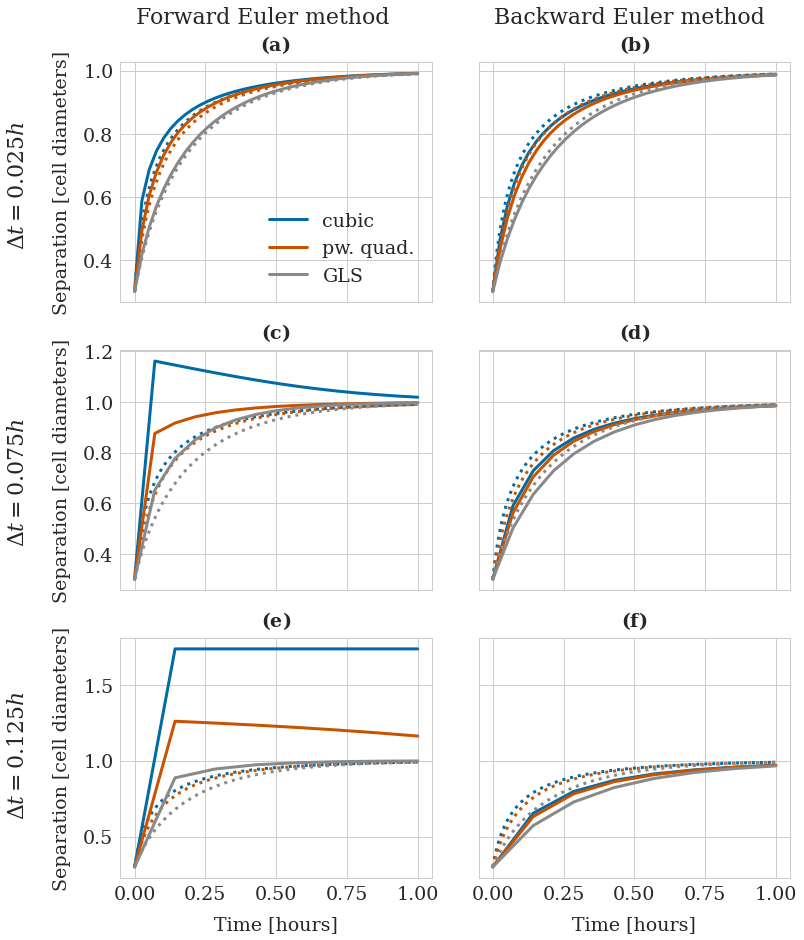

In [11]:
# Combine into single figure
fig, ((ax1, ax5), (ax2, ax6), (ax3, ax7)) = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

# ax1
for i, dt in enumerate(dt_values[1:2]):
    for force in force_names: 
        ax1.plot(np.linspace(0,tf,N[0]), sol_ef[force][0], color=colors[force], linestyle=linestyles[2])
        ax1.plot(np.linspace(0,tf,N[i+1]), sol_ef[force][i+1], label=force, color=colors[force], linestyle=linestyles[i])
ax1.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
ax1.legend()
ax1.set_title(r'$\bf{(a)}$ ')
ax1.label_outer()
ax1.text(-0.45, 0.45, '$\Delta t = 0.025h$', fontsize=22, rotation='vertical')
ax1.text(0.005, 1.15, 'Forward Euler method', fontsize=22)

# ax2
for i, dt in enumerate(dt_values[2:3]):
    for force in force_names: 
        ax2.plot(np.linspace(0,tf,N[0]), sol_ef[force][0], color=colors[force], linestyle=linestyles[2])
        ax2.plot(np.linspace(0,tf,N[i+2]), sol_ef[force][i+2], label=force, color=colors[force], linestyle=linestyles[i])
ax2.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#x2.legend()
ax2.set_title(r'$\bf{(c)}$')
ax2.label_outer()
ax2.text(-0.45, 0.45, '$\Delta t = 0.075h$', fontsize=22, rotation='vertical')

# ax3
for i, dt in enumerate(dt_values[4:5]):
    for force in force_names: 
        ax3.plot(np.linspace(0,tf,N[0]), sol_ef[force][0], color=colors[force], linestyle=linestyles[2])
        ax3.plot(np.linspace(0,tf,N[i+4]), sol_ef[force][i+4], label=force, color=colors[force], linestyle=linestyles[i])
ax3.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#ax3.legend()
ax3.set_title(r'$\bf{(e)}$')
ax3.label_outer()
ax3.text(-0.45, 0.65, '$\Delta t = 0.125h$', fontsize=22, rotation='vertical')

##ax4
#for i, dt in enumerate(dt_values[4:]):
#    for force in force_names: 
#        ax4.plot(np.linspace(0,tf,N[0]), sol_ef[force][0], color=colors[force], linestyle=linestyles[2])
#        ax4.plot(np.linspace(0,tf,N[i+4]), sol_ef[force][i+4], label=force, color=colors[force], linestyle=linestyles[i])
#ax4.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#ax4.legend(loc='upper center', bbox_to_anchor=(-0.7,-0.5,1.2,0.2), mode='expand', ncol=3, handlelength=1.5)
#ax4.set_title(r'$\bf{(g)}$')
#ax4.label_outer()
#ax4.text(-0.45, 0.45, '$\Delta t = 0.2h$', fontsize=22, rotation='vertical')

# ax5
for i, dt in enumerate(dt_values[1:2]):
    for force in force_names: 
        ax5.plot(np.linspace(0,tf,N[0]), sol_eb[force][0], color=colors[force], linestyle=linestyles[2])
        ax5.plot(np.linspace(0,tf,N[i+1]), sol_eb[force][i+1], label=force, color=colors[force], linestyle=linestyles[i])
ax5.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#ax5.legend()
ax5.set_title(r'$\bf{(b)}$')
ax5.label_outer()
ax5.text(0.005, 1.15, 'Backward Euler method', fontsize=22)

# ax6
for i, dt in enumerate(dt_values[2:3]):
    for force in force_names: 
        ax6.plot(np.linspace(0,tf,N[0]), sol_eb[force][0], color=colors[force], linestyle=linestyles[2])
        ax6.plot(np.linspace(0,tf,N[i+2]), sol_eb[force][i+2], label=force, color=colors[force], linestyle=linestyles[i])
ax6.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#x2.legend()
ax6.set_title(r'$\bf{(d)}$')
ax6.label_outer()

# ax7
for i, dt in enumerate(dt_values[4:5]):
    for force in force_names: 
        ax7.plot(np.linspace(0,tf,N[0]), sol_eb[force][0], color=colors[force], linestyle=linestyles[2])
        ax7.plot(np.linspace(0,tf,N[i+4]), sol_eb[force][i+4], label=force, color=colors[force], linestyle=linestyles[i])
ax7.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#ax3.legend()
ax7.set_title(r'$\bf{(f)}$')
ax7.label_outer()

#ax8
#for i, dt in enumerate(dt_values[4:]):
#    for force in force_names: 
#        ax8.plot(np.linspace(0,tf,N[0]), sol_eb[force][0], color=colors[force], linestyle=linestyles[2])
#        ax8.plot(np.linspace(0,tf,N[i+4]), sol_eb[force][i+4], label=force, color=colors[force], linestyle=linestyles[i])
#ax8.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
##ax4.legend(loc='upper center', bbox_to_anchor=(-0.7,-0.5,1.2,0.2), mode='expand', ncol=3, handlelength=1.5)
#ax8.set_title(r'$\bf{(h)}$')
#ax8.label_outer()
        
plt.savefig('stability.pdf', bbox_inches='tight')
#plt.savefig('EF_overshoot.png', bbox_inches='tight')

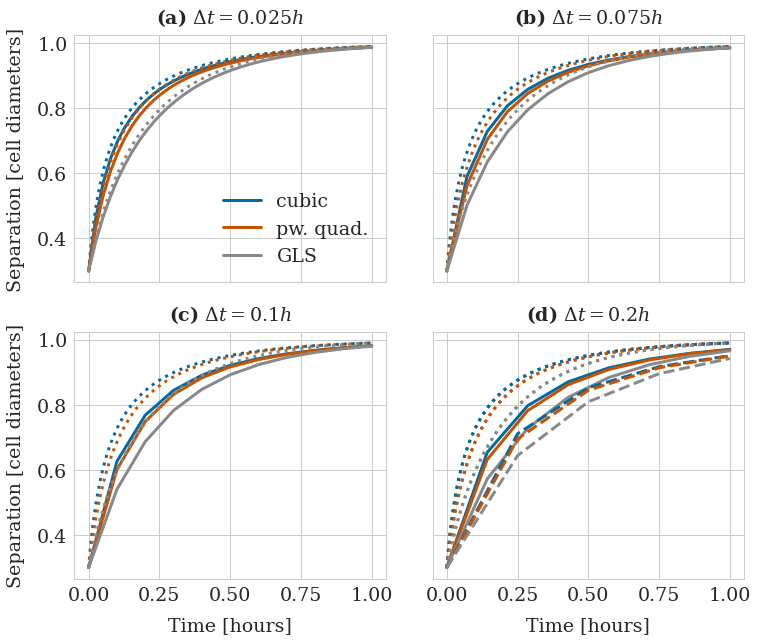

In [12]:
# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

# ax1
for i, dt in enumerate(dt_values[1:2]):
    for force in force_names: 
        ax1.plot(np.linspace(0,tf,N[0]), sol_eb[force][0], color=colors[force], linestyle=linestyles[2])
        ax1.plot(np.linspace(0,tf,N[i+1]), sol_eb[force][i+1], label=force, color=colors[force], linestyle=linestyles[i])
ax1.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
ax1.legend()
ax1.set_title(r'$\bf{(a)}$ $\Delta t = 0.025h$')
ax1.label_outer()

# ax2
for i, dt in enumerate(dt_values[2:3]):
    for force in force_names: 
        ax2.plot(np.linspace(0,tf,N[0]), sol_eb[force][0], color=colors[force], linestyle=linestyles[2])
        ax2.plot(np.linspace(0,tf,N[i+2]), sol_eb[force][i+2], label=force, color=colors[force], linestyle=linestyles[i])
ax2.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#x2.legend()
ax2.set_title(r'$\bf{(b)}$ $\Delta t = 0.075h$')
ax2.label_outer()

# ax3
for i, dt in enumerate(dt_values[3:4]):
    for force in force_names: 
        ax3.plot(np.linspace(0,tf,N[0]), sol_eb[force][0], color=colors[force], linestyle=linestyles[2])
        ax3.plot(np.linspace(0,tf,N[i+3]), sol_eb[force][i+3], label=force, color=colors[force], linestyle=linestyles[i])
ax3.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#ax3.legend()
ax3.set_title(r'$\bf{(c)}$ $\Delta t = 0.1h$')
ax3.label_outer()

#ax4
for i, dt in enumerate(dt_values[4:]):
    for force in force_names: 
        ax4.plot(np.linspace(0,tf,N[0]), sol_eb[force][0], color=colors[force], linestyle=linestyles[2])
        ax4.plot(np.linspace(0,tf,N[i+4]), sol_eb[force][i+4], label=force, color=colors[force], linestyle=linestyles[i])
ax4.set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
#ax4.legend(loc='upper center', bbox_to_anchor=(-0.7,-0.5,1.2,0.2), mode='expand', ncol=3, handlelength=1.5)
ax4.set_title(r'$\bf{(d)}$ $\Delta t = 0.2h$')
ax4.label_outer()

plt.savefig('EB_no_overshoot.pdf', bbox_inches='tight')
plt.savefig('EB_no_overshoot.png', bbox_inches='tight')